In [34]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

import numpy as np
import glob
from tqdm import tqdm


In [35]:
import utils.load_grid as lg
from utils.load_cmaps import *

In [36]:
case_dir = "data/article_data/jgr_grid_final/case_00714/"

In [37]:
nc_files = glob.glob(case_dir+"data/*_atm.nc")
times = [int(f.split("/")[-1].split("_")[0]) for f in nc_files]
mask = np.argsort(times)

sorted_t, sorted_f = [],[]
for i in mask:
    sorted_t.append(times[i])
    sorted_f.append(nc_files[i])
nfiles = len(sorted_t)
print(nfiles)

256


In [38]:
sorted_nc = []
pbar = tqdm(desc="NetCDFS", total=nfiles)
for i in range(nfiles):
    sorted_nc.append(lg.read_nc(sorted_f[i]))
    pbar.update(1)
print(" ")

NetCDFS: 100%|█████████▉| 255/256 [00:06<00:00, 44.23it/s]

In [39]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'
#plt.close("all")

xs = []  # times
ys = []  # pressures
zs = []  # values
rs = []  # radiating levels (pressure)

stride = 1

ybot, ytop = 1.0, 0.1
for i in range(2,nfiles,stride):
    nc = sorted_nc[i]
    xs.append(np.ones(np.shape(nc["p"]))*sorted_t[i])
    y = nc["p"] * 1.0e-5
    ys.append(y)
    zs.append(nc["fl_N"][1:]-nc["fl_N"][:-1])

    ybot = max(ybot, np.amax(y))
    ytop = min(ytop, np.amin(y))

    t_top = nc["tmp"][0]
    for j,tmp in enumerate(nc["tmp"]):
        if tmp > t_top + 0.001:
            if j > 1:
                rs.append(y[j])
            else:
                rs.append(np.nan)
            break 

minz, maxz = np.amin(zs), np.amax(zs)
absz = max(maxz, abs(minz))

x_plt, y_plt, z_plt = [],[],[]
for i in range(len(ys)):
    for j in range(len(ys[0])):
        x_plt.append(xs[i][j])
        y_plt.append(ys[i][j])
        z_plt.append(zs[i][j])
xi = np.linspace(np.amin(x_plt), np.amax(x_plt), 400)
yi = np.logspace(np.log10(np.amin(y_plt)), np.log10(np.amax(y_plt)), 150)
xi,yi = np.meshgrid(xi,yi)
zi = griddata((x_plt,y_plt),z_plt,(xi,yi),method='linear', rescale=True, fill_value=np.nan)

NetCDFS: 100%|██████████| 256/256 [00:17<00:00, 44.23it/s]

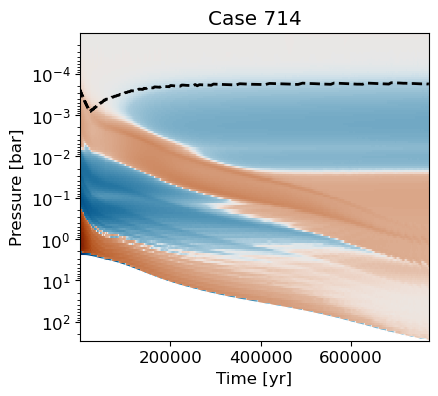

In [41]:
# fig
fig,ax = plt.subplots(1,1, figsize=(4.5,4))

# cmap
cmap = sci_colormaps["vik"]
norm = mpl.colors.SymLogNorm(linthresh=1, vmin=-absz, vmax=absz)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# plot data
cf = ax.pcolormesh(xi,yi,zi, norm=norm, cmap=cmap, rasterized=True)
# ax.scatter(x_plt, y_plt, c=z_plt, cmap=cmap, norm=norm, s=1, marker=',')

# plot decorations
x_1d = np.array(xs).T[0]
ax.plot(x_1d, rs, lw=2, color='k', linestyle='dashed')  # stratosphere level
ax.fill_between(x_1d, np.ones(np.shape(x_1d))*1e99, np.array(ys).T[-1], color='white') # surface pressure

# colorbar
# cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
# cbar = fig.colorbar(sm, cax=cax, orientation='vertical') 
# cbar.set_label(r"Flux difference [W m$^{-2}$]")

# configure
case_num = int(case_dir.split("case_")[-1][:-1])
ax.set_yscale("log")
ax.set_ylabel("Pressure [bar]")
ax.set_xlabel("Time [yr]")
ax.set_title("Case %d"%case_num)

ax.set_xlim(1e3, sorted_t[-1])
ax.set_ylim(ybot, ytop)

# save
fig.savefig("output/recent_fluxdiff_%05d.pdf"%case_num, bbox_inches='tight', dpi=200)